<a href="https://colab.research.google.com/github/Max-FM/ICG_GEM_Innovation_Workshop_17_Nov_2021/blob/main/submitted_notebooks/ICG_GEM_Innovation_Hack_2021_11_17_MaxFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICG GEM Innovation Hack Hour 17th Nov 2021
### Author: Max Foxley-Marrable

If you are accessing this Colab notebook through the shared Google Drive Folder, please make your own copy by clicking File -> Save a copy in Drive.

## Install rioxarray package

In [1]:
%%capture

!pip install rioxarray

## Import Required Modules

In [2]:
import numpy as np
import pandas as pd
import xarray as xa
import rioxarray as riox


import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num, num2date
import seaborn as sns

from pathlib import Path

In [3]:
sns.set_theme("talk")
sns.set_style("darkgrid")

## Define Functions

In [4]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_rgb_composite(raster):
    """Creates an RGB composite image using the input raster."""
    r = raster[2]
    g = raster[1]
    b = raster[0]

    return make_composite(r, g, b)

def calculate_ndvi(raster):
    """Calculates the normalised difference vegetation index using the input raster."""
    r = raster[2]
    nir = raster[3]

    return (nir - r) / (nir + r)

def calculate_ndwi(raster):
    """Calculates the McFeeters (1996) normalised difference water index using the input raster."""
    g = raster[1]
    nir = raster[3]

    return (g - nir) / (g + nir)

## Shamshato Time Series Data

Here I am attempting to extract NDVI and NDWI timeseries data from the Sentinel 2 images. I then present timeseries regression plots showing the general trend of NDVI and NDWI over time, as well as showing a relationship between the chosen NDVI and NDWI metrics.

#### Extracting the Time Series Data

In [5]:
%%time

filepath_gen = Path(f'/content/drive/Shareddrives/ICG Data Analytics/Data/Pakistan/Shamshato').rglob('*/Sentinel_2_SR/*.tif')
filepaths = [file for file in filepath_gen if file.is_file()]
no_of_files = len(filepaths)

# Sets up dummpy arrays/lists to be amended.
median_ndvi = np.empty(no_of_files)
median_ndwi = np.empty(no_of_files)
date_list = []

# Recursively iterating through each Sentinel 2 image in the Shamshato folder.
for index, path in enumerate(filepaths):
    # Load in raster.
    raster = riox.open_rasterio(path) / 10000
    
    # Extract date from filestring and append to list.
    date_list.append(f"{path.name[:4]}-{path.name[4:6]}-{path.name[6:8]}")
    
    # Calculate median NDVI and NDWI and append to relevant lists.
    median_ndvi[index] = calculate_ndvi(raster).median()
    median_ndwi[index] = calculate_ndwi(raster).median()

CPU times: user 2min 5s, sys: 4.58 s, total: 2min 10s
Wall time: 2min 15s


In [6]:
# Insert extracted data to Pandas DataFrame.
df = pd.DataFrame(
    {
        "date": np.array(date_list),
        "datenum": datestr2num(date_list), # Converts dates to floats as some plotting functions do not accept str or datetime values.
        "ndvi": median_ndvi,
        "ndwi": median_ndwi,
    }
)

df

,date,datenum,ndvi,ndwi
0,2019-01-06,737065.0,0.202787,-0.329239
1,2019-01-06,737065.0,0.175995,-0.321979
2,2019-01-09,737068.0,0.183348,-0.291621
3,2019-01-09,737068.0,0.183054,-0.305473
4,2019-01-24,737083.0,0.178275,-0.290985
...,...,...,...,...
585,2021-11-04,738098.0,0.144623,-0.174336
586,2021-11-11,738105.0,0.241206,-0.348514
587,2021-11-11,738105.0,0.234791,-0.328554
588,2021-11-14,738108.0,0.202589,-0.289973


### Plotting Time-Series Regression Plots using Seaborn

In [7]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return num2date(x).strftime('%Y-%m-%d')

#### NDVI Timeseries

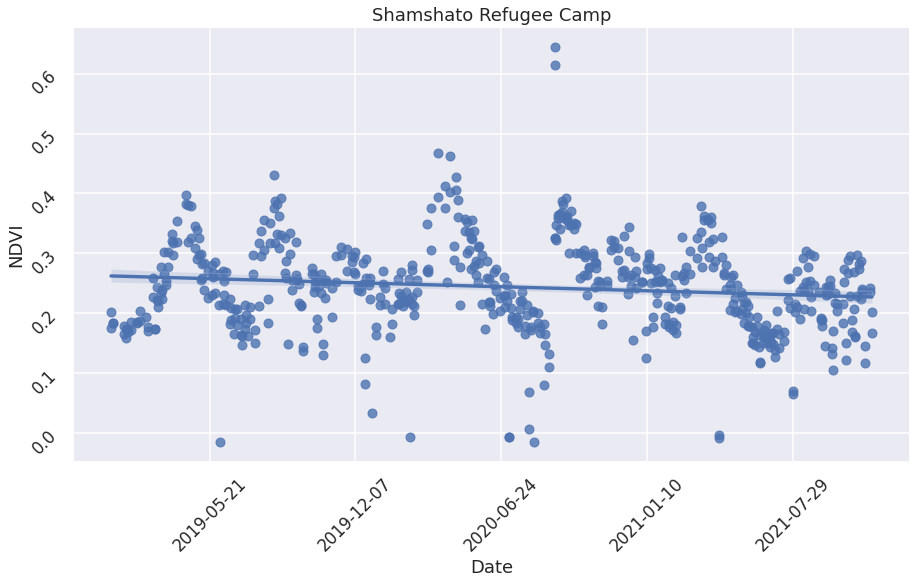

In [8]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x='datenum', y='ndvi', data=df, ax=ax)
ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("Shamshato Refugee Camp")
plt.savefig("/content/drive/Shareddrives/ICG Data Analytics/Events/2021-11-17 Innovation Monthly Meeting/Plots/Shamshato_Median_NDVI_Timeseries_Regression_MaxFM.png", bbox_inches="tight")

#### NDWI Timeseries

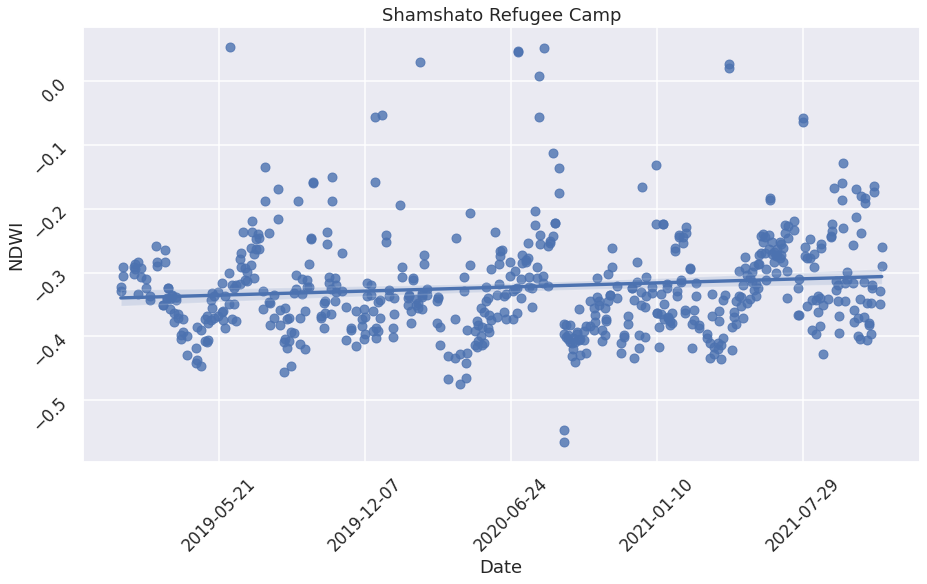

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x='datenum', y='ndwi', data=df, ax=ax)
ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)
plt.xlabel("Date")
plt.ylabel("NDWI")
plt.title("Shamshato Refugee Camp")
plt.savefig("/content/drive/Shareddrives/ICG Data Analytics/Events/2021-11-17 Innovation Monthly Meeting/Plots/Shamshato_Median_NDWI_Timeseries_Regression_MaxFM.png", bbox_inches="tight")

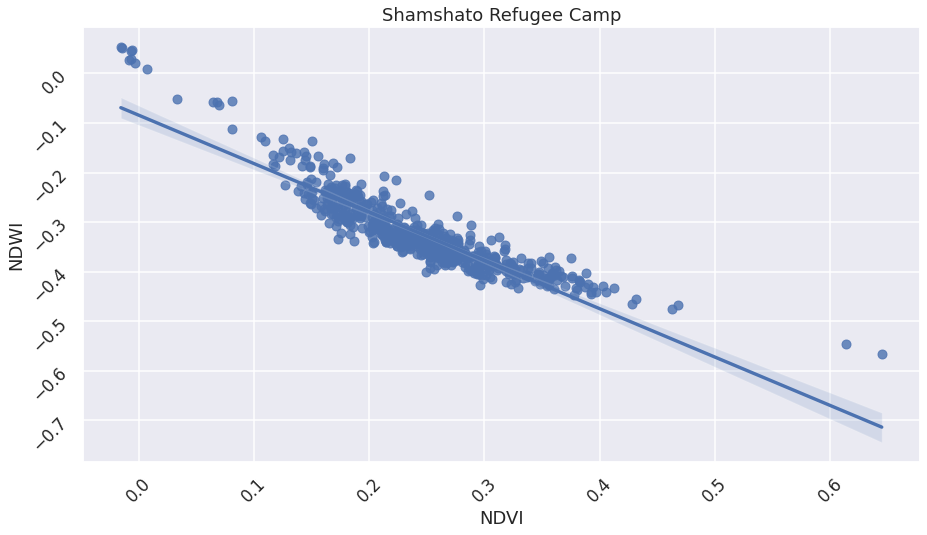

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x='ndvi', y='ndwi', data=df, ax=ax)
ax.tick_params(labelrotation=45)
plt.xlabel("NDVI")
plt.ylabel("NDWI")
plt.title("Shamshato Refugee Camp")
plt.savefig("/content/drive/Shareddrives/ICG Data Analytics/Events/2021-11-17 Innovation Monthly Meeting/Plots/Shamshato_Median_NDVI_NDWI_Regression_MaxFM.png", bbox_inches="tight")